# Lecture 4 — From Regression to Classification: Building Logistic Regression from Scratch

Welcome to **Lecture 4** of *Practical Introduction to Machine Learning and Deep Learning*!  
This lecture is part of the **SAIR ML/DL Roadmap & Bootcamp**.

## 🌱 Why This Lecture Matters  

In **Lecture 1**, we learned about **Linear Regression** — predicting **continuous values** like house prices.  
But what if we want to predict **categories** instead?  

- Is this email **spam or not spam**?  
- Will a customer **buy or not buy**?  
- Is this tumor **malignant or benign**?

These are **classification problems**, and we need a different approach.

> *"Linear Regression predicts numbers. Logistic Regression predicts probabilities."*

## 📖 What You'll Learn

1. **Why linear regression fails for classification**
2. **The sigmoid function and probability interpretation**
3. **Binary Cross-Entropy loss (why not MSE?)**
4. **Deriving gradients for logistic regression**
5. **Implementing logistic regression from scratch**
6. **Benchmarking against scikit-learn**
7. **Visualizing decision boundaries**
8. **Extending to multi-class classification with Softmax**
9. **Categorical Cross-Entropy and multi-class gradients**
10. **Real-world applications and comparisons**

---

## 🧠 The Core Idea

**Linear Regression:**  
$$
\hat{y} = \mathbf{X}\mathbf{W} + b
$$
Output: any real number $(-\infty, +\infty)$

**Logistic Regression:**  
$$
\hat{y} = \sigma(\mathbf{X}\mathbf{W} + b)
$$
Output: probability between $(0, 1)$

Where $\sigma$ is the **sigmoid function**:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

💡 **Key Insight:** We squeeze the linear output through a sigmoid to get probabilities!

## Part 1: Binary Classification with Logistic Regression

### Step 1️⃣ — Why Linear Regression Doesn't Work for Classification

Let's see what happens when we try to use linear regression for a binary classification problem.

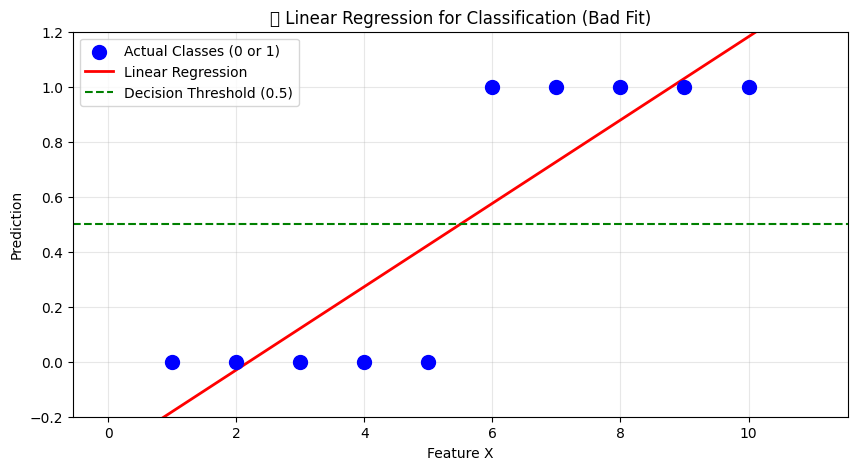

⚠️ Notice: Linear regression can predict values < 0 or > 1
These don't make sense as probabilities!


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple binary classification dataset
np.random.seed(42)
X_class = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).reshape(-1, 1)
y_class = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]).reshape(-1, 1)

# Fit a simple linear regression
X_with_bias = np.column_stack([np.ones(len(X_class)), X_class])
W_linear = np.linalg.lstsq(X_with_bias, y_class, rcond=None)[0]

# Plot
x_line = np.linspace(0, 11, 100)
y_line = W_linear[0] + W_linear[1] * x_line

plt.figure(figsize=(10, 5))
plt.scatter(X_class, y_class, color='blue', s=100, label='Actual Classes (0 or 1)', zorder=3)
plt.plot(x_line, y_line, color='red', linewidth=2, label='Linear Regression')
plt.axhline(y=0.5, color='green', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel('Feature X')
plt.ylabel('Prediction')
plt.title('❌ Linear Regression for Classification (Bad Fit)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.2, 1.2)
plt.show()

print("⚠️ Notice: Linear regression can predict values < 0 or > 1")
print("These don't make sense as probabilities!")

### 🧩 Step 2️⃣ — The Sigmoid Function: Turning Scores into Probabilities  

When we used **linear regression** for classification, our predictions could be **any real number** — like `-3`, `0.7`, or `2.4`.  
But probabilities **must** always stay between **0 and 1**.  

So how can we *squash* any number into that range?  
That’s exactly what the **sigmoid function** does.

---

#### ⚙️ The Formula  

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This simple-looking formula performs a magic trick:
- It takes any real number \( z \in (-\infty, +\infty) \)
- And transforms it into a smooth curve that always stays between **0** and **1**

---

#### 🧠 Intuition  

Think of the sigmoid as a **soft switch**:
- When \( z \) is **very negative**, \( e^{-z} \) becomes huge → \( \sigma(z) \approx 0 \)
- When \( z = 0 \), \( e^{-z} = 1 \) → \( \sigma(0) = 0.5 \)
- When \( z \) is **very positive**, \( e^{-z} \) becomes tiny → \( \sigma(z) \approx 1 \)

Instead of jumping sharply from 0 to 1, the sigmoid **smoothly transitions**,  
making it perfect for modeling probabilities and uncertainty.

---

#### 📈 Key Properties  

| Property | Meaning |
|-----------|----------|
| \( \sigma(0) = 0.5 \) | The “tipping point” — equally uncertain between classes |
| \( \sigma(z) \to 1 \) as \( z \to +\infty \) | Very confident it’s class 1 |
| \( \sigma(z) \to 0 \) as \( z \to -\infty \) | Very confident it’s class 0 |
| Range: \( (0, 1) \) | Always a valid probability |
| Smooth & differentiable | Perfect for optimization with gradient descent |

---

#### 🎯 Why It Matters  

The sigmoid function lets us turn our linear model’s raw score  
\[
z = w_0 + w_1x
\]
into a **probability estimate**:

\[
P(y = 1 \mid x) = \sigma(z)
\]

This is the key idea behind **Logistic Regression** —  
a linear model whose outputs are “passed through” a sigmoid to make them probabilistic.

---

🧭 **In short:**  
The sigmoid is the mathematical bridge between **linear outputs** and **probabilistic predictions** —  
it converts “scores” into “beliefs.”


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-z))

# Generate z values
z_values = np.linspace(-10, 10, 11)
sigmoid_values = sigmoid(z_values)


print("z values:",z_values)
print("sigmoid values:",sigmoid_values)

# Show in a neat table
table = pd.DataFrame({
    "z (Linear Score)": z_values,
    "σ(z) (Probability)": np.round(sigmoid_values, 4)
})

print(table)


z values: [-10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.]
sigmoid values: [4.53978687e-05 3.35350130e-04 2.47262316e-03 1.79862100e-02
 1.19202922e-01 5.00000000e-01 8.80797078e-01 9.82013790e-01
 9.97527377e-01 9.99664650e-01 9.99954602e-01]
    z (Linear Score)  σ(z) (Probability)
0              -10.0              0.0000
1               -8.0              0.0003
2               -6.0              0.0025
3               -4.0              0.0180
4               -2.0              0.1192
5                0.0              0.5000
6                2.0              0.8808
7                4.0              0.9820
8                6.0              0.9975
9                8.0              0.9997
10              10.0              1.0000


/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


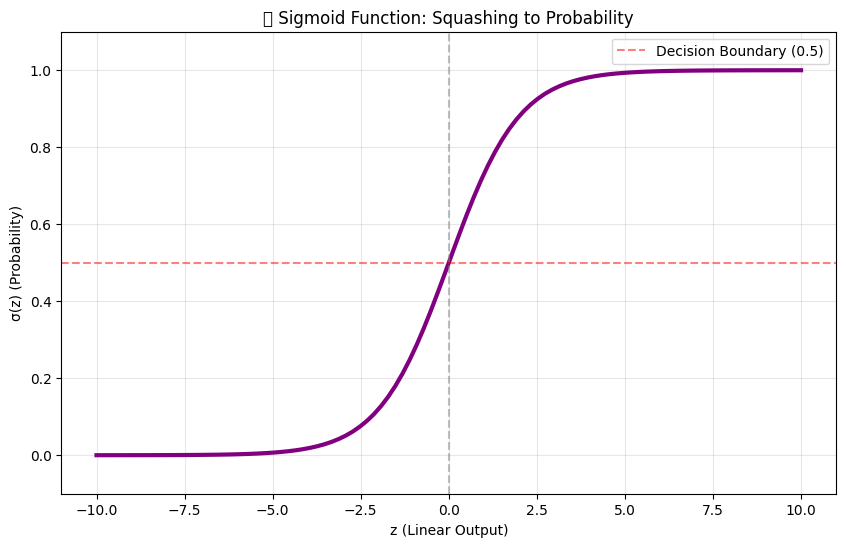

original z values: [-10.          -9.7979798   -9.5959596   -9.39393939  -9.19191919
  -8.98989899  -8.78787879  -8.58585859  -8.38383838  -8.18181818
  -7.97979798  -7.77777778  -7.57575758  -7.37373737  -7.17171717
  -6.96969697  -6.76767677  -6.56565657  -6.36363636  -6.16161616
  -5.95959596  -5.75757576  -5.55555556  -5.35353535  -5.15151515
  -4.94949495  -4.74747475  -4.54545455  -4.34343434  -4.14141414
  -3.93939394  -3.73737374  -3.53535354  -3.33333333  -3.13131313
  -2.92929293  -2.72727273  -2.52525253  -2.32323232  -2.12121212
  -1.91919192  -1.71717172  -1.51515152  -1.31313131  -1.11111111
  -0.90909091  -0.70707071  -0.50505051  -0.3030303   -0.1010101
   0.1010101    0.3030303    0.50505051   0.70707071   0.90909091
   1.11111111   1.31313131   1.51515152   1.71717172   1.91919192
   2.12121212   2.32323232   2.52525253   2.72727273   2.92929293
   3.13131313   3.33333333   3.53535354   3.73737374   3.93939394
   4.14141414   4.34343434   4.54545455   4.74747475   4.9

In [10]:
# Visualize sigmoid
z_values = np.linspace(-10, 10, 100)
sigmoid_values = sigmoid(z_values)

plt.figure(figsize=(10, 6))
plt.plot(z_values, sigmoid_values, linewidth=3, color='purple')
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Decision Boundary (0.5)')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('z (Linear Output)')
plt.ylabel('σ(z) (Probability)')
plt.title('📊 Sigmoid Function: Squashing to Probability')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(-0.1, 1.1)
plt.show()

print("original z values:",z_values)

print("Key points:")
print(f"σ(-5) = {sigmoid(-5):.4f} → Strong prediction for class 0")
print(f"σ(0)  = {sigmoid(0):.4f} → Uncertain")
print(f"σ(5)  = {sigmoid(5):.4f} → Strong prediction for class 1")

### Step 3️⃣ — Logistic Regression Model

Now we combine linear regression with the sigmoid:

**Step 1:** Compute linear combination  
$$
z = \mathbf{X}\mathbf{W} + b
$$

**Step 2:** Apply sigmoid to get probability  
$$
\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Step 3:** Make prediction  
$$
\text{Predicted Class} = \begin{cases} 
1 & \text{if } \hat{y} \geq 0.5 \\
0 & \text{if } \hat{y} < 0.5
\end{cases}
$$

/tmp/ipykernel_192477/687489672.py:49: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192477/687489672.py:49: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


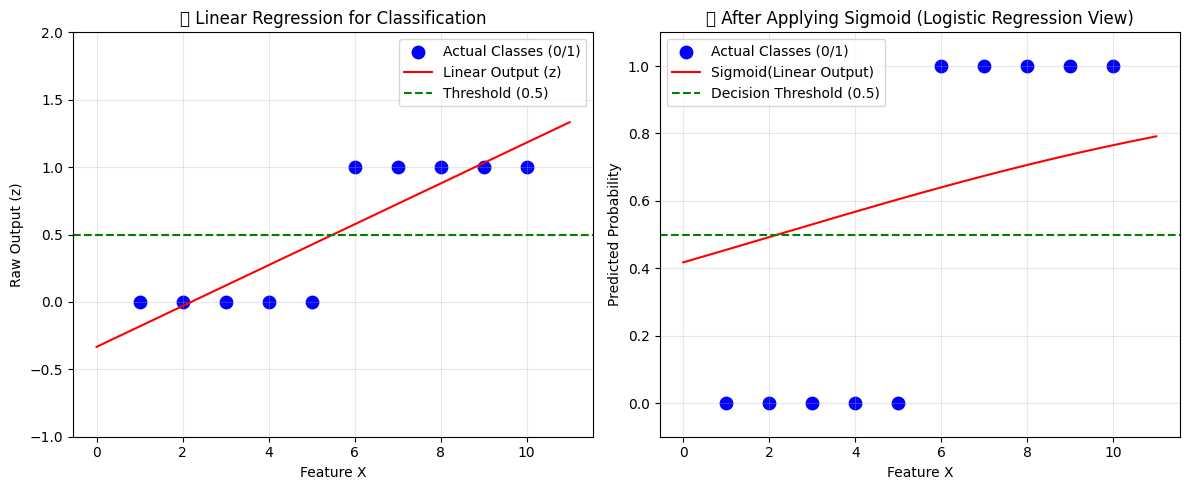

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1️⃣: Create a simple binary dataset ---
X = np.arange(1, 11).reshape(-1, 1)
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

# --- Step 2️⃣: Fit Linear Regression using least squares ---
X_with_bias = np.c_[np.ones(len(X)), X]
w = np.linalg.lstsq(X_with_bias, y, rcond=None)[0]   # [b, w]

# Predictions (raw linear scores)
x_line = np.linspace(0, 11, 200)
z_linear = w[0] + w[1] * x_line

# --- Step 3️⃣: Apply sigmoid to get probabilities ---
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

y_sigmoid = sigmoid(z_linear)

# --- Step 4️⃣: Plot before vs after sigmoid ---
plt.figure(figsize=(12, 5))

# (a) Linear Regression
plt.subplot(1, 2, 1)
plt.scatter(X, y, color='blue', s=80, label='Actual Classes (0/1)')
plt.plot(x_line, z_linear, 'r-', label='Linear Output (z)')
plt.axhline(0.5, color='green', ls='--', label='Threshold (0.5)')
plt.title("❌ Linear Regression for Classification")
plt.xlabel("Feature X")
plt.ylabel("Raw Output (z)")
plt.ylim(-1, 2)
plt.legend()
plt.grid(alpha=0.3)

# (b) Logistic (Sigmoid Applied)
plt.subplot(1, 2, 2)
plt.scatter(X, y, color='blue', s=80, label='Actual Classes (0/1)')
plt.plot(x_line, y_sigmoid, 'r-', label='Sigmoid(Linear Output)')
plt.axhline(0.5, color='green', ls='--', label='Decision Threshold (0.5)')
plt.title("✅ After Applying Sigmoid (Logistic Regression View)")
plt.xlabel("Feature X")
plt.ylabel("Predicted Probability")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Step 4️⃣ — Why Binary Cross-Entropy (Log Loss) is Better Than MSE

When we moved from **linear regression → logistic regression**, we also need to choose the **right loss function**.

---

#### 1️⃣ Why MSE (Mean Squared Error) is not ideal for classification

MSE formula:
$$
\text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

- Works great when **outputs are continuous numbers**.
- Problem for classification:
  1. Sigmoid outputs are probabilities (0–1), but MSE treats errors **linearly**, which can slow down learning when predictions are **confident but wrong**.
  2. For a sigmoid, the derivative of MSE wrt weights has an extra factor from the chain rule, which **squashes gradients** when the output is near 0 or 1 → learning is slow.
  3. MSE doesn’t penalize wrong predictions as sharply as we want.

---

#### 🔍 Step-by-Step Intuition

Suppose true label \(y = 1\) and our model predicts \(\hat{y} = 0.01\):

- **MSE loss:**  
$$
(0.01 - 1)^2 = 0.9801
$$
- **BCE loss:**  
$$
- \log(0.01) \approx 4.605
$$

> BCE punishes confident wrong predictions **much more**, forcing the model to correct them faster.

---

#### 2️⃣ Binary Cross-Entropy (BCE) — the Right Choice

Formula:
$$
\text{BCE} = -\frac{1}{m}\sum_{i=1}^{m}\left[y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\right]
$$

Intuition:

| True label \(y\) | What we want | Loss term |
|-----------------|-------------|-----------|
| 1               | \(\hat{y}\) → 1 | \(-\log(\hat{y})\) |
| 0               | \(\hat{y}\) → 0 | \(-\log(1-\hat{y})\) |

- If \(\hat{y}\) is close to **true class**, loss → small  
- If \(\hat{y}\) is **very wrong**, loss → huge → model corrects quickly  
- Works naturally with **sigmoid outputs**


#### 4️⃣ Compute BCE for a small dataset (step-by-step)


In [13]:
y_true = np.array([0, 0, 1, 1])
y_pred_linear = np.array([0.2, 0.4, 0.6, 0.9])       # linear regression outputs (0-1)

# Apply sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

y_pred = sigmoid(y_pred_linear)

# Binary cross-entropy
bce = - np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
print("Binary Cross-Entropy Loss:", bce)

Binary Cross-Entropy Loss: 0.6224489867498795


### Step 4️⃣.5 — Motivation for the Binary Cross-Entropy Formula

The BCE (Log Loss) formula is:

$$
\text{BCE} = - \frac{1}{m} \sum_{i=1}^{m} \Big[y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)\Big]
$$

Let’s understand **why the log and the negative sign appear**.

---

#### 1️⃣ Why use the **logarithm**?

Intuition:  
- Sigmoid outputs are probabilities between 0 and 1.  
- We want a **loss that heavily penalizes confident but wrong predictions**.

Example:  
- True label: \(y = 1\)  
- Prediction: \(\hat{y} = 0.01\) (very wrong!)  

- Linear difference: \((1 - 0.01)^2 = 0.9801\) → not “dramatic enough”  
- Logarithmic penalty: \(-\log(0.01) \approx 4.605\) → **much stronger penalty**

✅ **Why log?**
- Logarithm grows very large as probability approaches 0 (for \(y=1\))  
- Logarithm grows very large as probability approaches 1 (for \(y=0\))  
- Smoothly penalizes predictions near the wrong end, without exploding numerically for moderate values  

---

#### 2️⃣ Why the **negative sign**?

- \(\log(p)\) is negative if \(0 < p < 1\).  
- Since we want **loss ≥ 0**, we multiply by **-1**:

\[
-\log(p) \ge 0
\]

- Example:
  - If \(\hat{y} = 0.9\) and \(y = 1\): \(-\log(0.9) \approx 0.105\) → small loss  
  - If \(\hat{y} = 0.01\) and \(y = 1\): \(-\log(0.01) \approx 4.605\) → big loss  

> The negative sign ensures the loss is **positive and intuitive**: smaller = better.

---

#### 3️⃣ Why combine the two terms: \(y \log(\hat{y}) + (1-y)\log(1-\hat{y})\)?

- Only **one term matters** for each label:
  - If \(y=1\): first term = \(\log(\hat{y})\), second term = 0 → loss = \(-\log(\hat{y})\)  
  - If \(y=0\): first term = 0, second term = \(\log(1-\hat{y})\) → loss = \(-\log(1-\hat{y})\)  

This way, BCE **automatically selects the correct penalty** depending on the true class.

---

#### 4️⃣ Visualize the log penalty


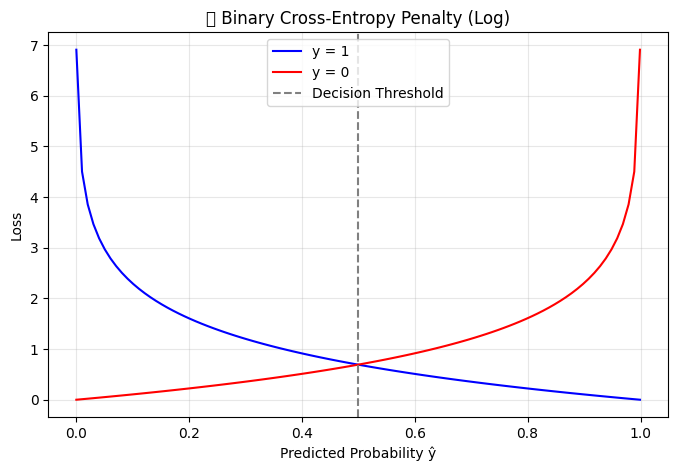

In [15]:
import numpy as np
import matplotlib.pyplot as plt

y_true_1 = 1
y_true_0 = 0
y_pred = np.linspace(0.001, 0.999, 100)  # avoid log(0)

# BCE components
loss_if_1 = -np.log(y_pred)
loss_if_0 = -np.log(1 - y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_pred, loss_if_1, label='y = 1', color='blue')
plt.plot(y_pred, loss_if_0, label='y = 0', color='red')
plt.axvline(0.5, color='gray', linestyle='--', label='Decision Threshold')
plt.title("🔹 Binary Cross-Entropy Penalty (Log)")
plt.xlabel("Predicted Probability ŷ")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

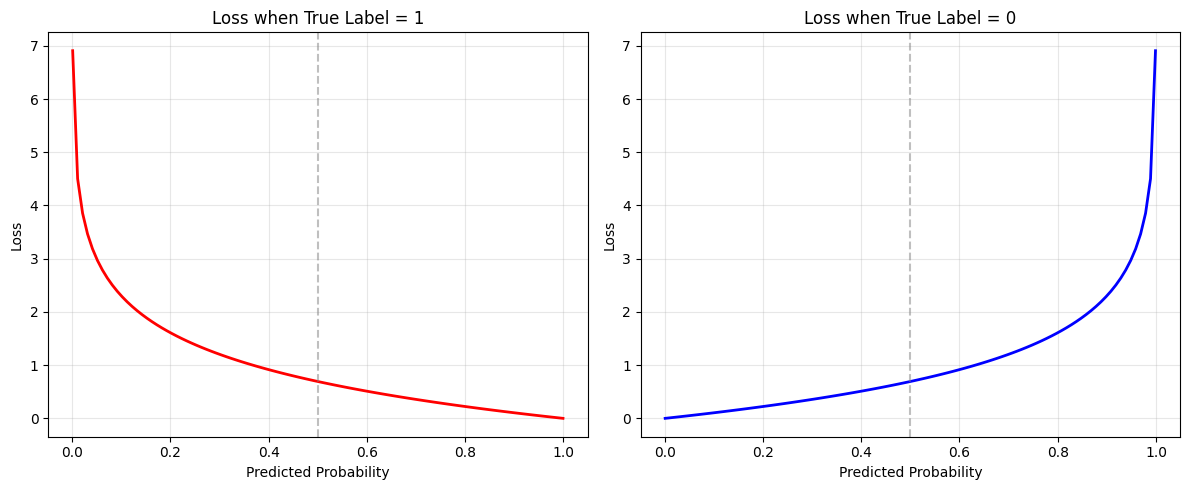

💡 Key Insight:
When y=1, predicting 0.01 gives huge loss!
When y=0, predicting 0.99 gives huge loss!
This strongly discourages confident wrong predictions.


In [4]:
# Visualize BCE loss
y_pred = np.linspace(0.001, 0.999, 100)  # avoid log(0)

# Loss when true label is 1
loss_when_y1 = -np.log(y_pred)

# Loss when true label is 0
loss_when_y0 = -np.log(1 - y_pred)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(y_pred, loss_when_y1, color='red', linewidth=2)
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.title('Loss when True Label = 1')
plt.grid(True, alpha=0.3)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(y_pred, loss_when_y0, color='blue', linewidth=2)
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.title('Loss when True Label = 0')
plt.grid(True, alpha=0.3)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("💡 Key Insight:")
print("When y=1, predicting 0.01 gives huge loss!")
print("When y=0, predicting 0.99 gives huge loss!")
print("This strongly discourages confident wrong predictions.")

### Step 5️⃣ — Gradient Descent for Logistic Regression

To update our weights, we need gradients of the loss w.r.t. weights and bias.

**Spoiler:** The gradient has a beautiful, simple form!

$$
\frac{\partial \text{BCE}}{\partial \mathbf{W}} = \frac{1}{m}\mathbf{X}^T(\hat{y} - y)
$$

$$
\frac{\partial \text{BCE}}{\partial b} = \frac{1}{m}\sum(\hat{y} - y)
$$

💡 **Notice:** This looks very similar to linear regression gradients!  
The sigmoid's derivative elegantly cancels with the log loss derivative.

---
#### 1️⃣ Intuition: Linear vs Logistic Gradients

| Concept | Linear Regression | Logistic Regression |
|---------|-----------------|------------------|
| Prediction | $$\hat{y} = XW + b$$ | $$\hat{y} = \sigma(XW + b)$$ |
| Error term | $$\hat{y} - y$$ | $$\hat{y} - y$$ |
| Gradient formula | $$\frac{2}{m} X^T (\hat{y}-y) \quad \text{(factor 2 from MSE)}$$ | $$\frac{1}{m} X^T (\hat{y}-y)$$ |
| Difference | Raw error | Error in **probability space** |

✅ Same **formula**, but logistic regression is probability-aware — steeply punishes confident mistakes.

In [22]:
# Sample data
X = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
y = np.array([0,0,0,0,0,1,1,1,1,1]).reshape(-1,1)

# Initialize weights
w = np.zeros((1,1))
b = 0
lr = 0.01
m = len(X)
epochs = 10000

# Forward + backward pass
for i in range(epochs):
    z = X @ w + b
    y_hat = sigmoid(z)
    dw = (1/m) * X.T @ (y_hat - y)
    db = (1/m) * np.sum(y_hat - y)
    w -= lr * dw
    b -= lr * db

print("Trained weight:", w)
print("Trained bias:", b)


Trained weight: [[1.07953121]]
Trained bias: -5.661862466869317


### Step 6️⃣ — Create a Binary Classification Dataset

Let's create a simple 2D dataset where we can visualize the decision boundary.

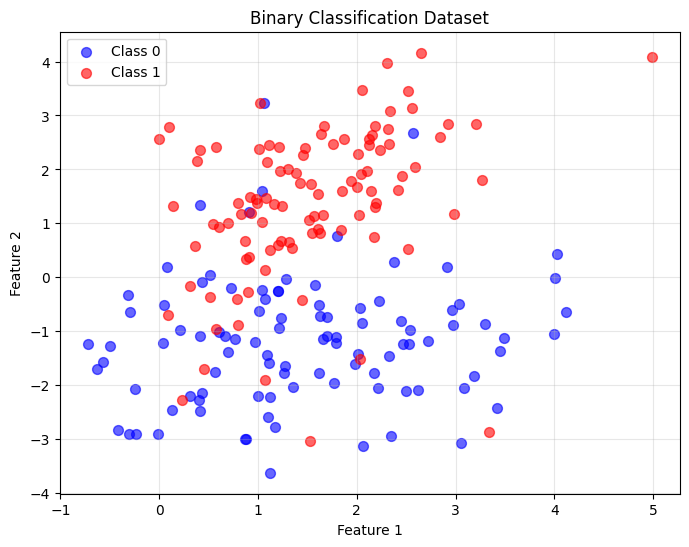

Dataset shape: X (200, 2), y (200, 1)
Class distribution: [ 99 101]


In [23]:
from sklearn.datasets import make_classification

# Generate synthetic binary classification data
np.random.seed(42)
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.1,
    class_sep=1.5,
    random_state=42
)

y = y.reshape(-1, 1)  # reshape for consistency

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X[y.flatten() == 0, 0], X[y.flatten() == 0, 1], 
            color='blue', label='Class 0', alpha=0.6, s=50)
plt.scatter(X[y.flatten() == 1, 0], X[y.flatten() == 1, 1], 
            color='red', label='Class 1', alpha=0.6, s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Binary Classification Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset shape: X {X.shape}, y {y.shape}")
print(f"Class distribution: {np.bincount(y.flatten())}")

### Step 7️⃣ — Implement Logistic Regression Class

Following the same OOP design principles from Lecture 1, we'll build a clean, reusable implementation.

In [24]:
class LogisticRegression:
    def __init__(self, n_features, lr=0.01):
        """
        Initialize Logistic Regression model
        
        Args:
            n_features: number of input features
            lr: learning rate
        """
        self.W = np.random.randn(n_features, 1) * 0.01
        self.b = np.zeros((1, 1))
        self.lr = lr
        self.losses = []
        self.accuracies = []
    
    def sigmoid(self, z):
        """Sigmoid activation function"""
        # Clip to prevent overflow
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def forward(self, X):
        """
        Forward pass: compute predictions
        
        Args:
            X: input features (m, n)
        
        Returns:
            predictions: probabilities (m, 1)
        """
        z = X @ self.W + self.b
        return self.sigmoid(z)
    
    def compute_loss(self, y_pred, y_true):
        """
        Compute Binary Cross-Entropy loss
        
        Args:
            y_pred: predicted probabilities (m, 1)
            y_true: true labels (m, 1)
        
        Returns:
            loss: scalar BCE loss
        """
        # Clip predictions to prevent log(0)
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        m = len(y_true)
        loss = -np.mean(
            y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
        )
        return loss
    
    def compute_accuracy(self, y_pred, y_true):
        """
        Compute classification accuracy
        
        Args:
            y_pred: predicted probabilities (m, 1)
            y_true: true labels (m, 1)
        
        Returns:
            accuracy: percentage of correct predictions
        """
        predictions = (y_pred >= 0.5).astype(int)
        return np.mean(predictions == y_true) * 100
    
    def backward(self, X, y_pred, y_true):
        """
        Compute gradients
        
        Args:
            X: input features (m, n)
            y_pred: predicted probabilities (m, 1)
            y_true: true labels (m, 1)
        
        Returns:
            dW: gradient w.r.t weights
            db: gradient w.r.t bias
        """
        m = len(y_true)
        dW = (1/m) * (X.T @ (y_pred - y_true))
        db = (1/m) * np.sum(y_pred - y_true)
        return dW, db
    
    def step(self, dW, db):
        """Update parameters"""
        self.W -= self.lr * dW
        self.b -= self.lr * db
    
    def fit(self, X, y, epochs=1000, verbose=True):
        """
        Train the model
        
        Args:
            X: training features (m, n)
            y: training labels (m, 1)
            epochs: number of training iterations
            verbose: whether to print progress
        """
        for i in range(epochs):
            # Forward pass
            y_pred = self.forward(X)
            
            # Compute loss and accuracy
            loss = self.compute_loss(y_pred, y)
            acc = self.compute_accuracy(y_pred, y)
            
            self.losses.append(loss)
            self.accuracies.append(acc)
            
            # Backward pass
            dW, db = self.backward(X, y_pred, y)
            
            # Update parameters
            self.step(dW, db)
            
            if verbose and (i % 100 == 0 or i == epochs - 1):
                print(f"Epoch {i:4d} | Loss: {loss:.4f} | Accuracy: {acc:.2f}%")
    
    def predict(self, X):
        """
        Make predictions on new data
        
        Args:
            X: input features (m, n)
        
        Returns:
            predictions: binary predictions (m, 1)
        """
        y_pred = self.forward(X)
        return (y_pred >= 0.5).astype(int)
    
    def predict_proba(self, X):
        """
        Get probability predictions
        
        Args:
            X: input features (m, n)
        
        Returns:
            probabilities: predicted probabilities (m, 1)
        """
        return self.forward(X)

### Step 8️⃣ — Train Our Model

Let's train our logistic regression model on the dataset we created.

In [25]:
# Create and train model
model = LogisticRegression(n_features=2, lr=0.1)
model.fit(X, y, epochs=1000, verbose=True)

print("\n✅ Training Complete!")
print(f"Final Loss: {model.losses[-1]:.4f}")
print(f"Final Accuracy: {model.accuracies[-1]:.2f}%")

Epoch    0 | Loss: 0.6939 | Accuracy: 50.50%
Epoch  100 | Loss: 0.3814 | Accuracy: 88.00%
Epoch  200 | Loss: 0.3795 | Accuracy: 88.50%
Epoch  300 | Loss: 0.3789 | Accuracy: 88.50%
Epoch  400 | Loss: 0.3786 | Accuracy: 88.00%
Epoch  500 | Loss: 0.3785 | Accuracy: 88.00%
Epoch  600 | Loss: 0.3784 | Accuracy: 88.50%
Epoch  700 | Loss: 0.3784 | Accuracy: 88.50%
Epoch  800 | Loss: 0.3783 | Accuracy: 88.50%
Epoch  900 | Loss: 0.3783 | Accuracy: 88.50%
Epoch  999 | Loss: 0.3783 | Accuracy: 88.00%

✅ Training Complete!
Final Loss: 0.3783
Final Accuracy: 88.00%


### Step 9️⃣ — Visualize Training Progress

/tmp/ipykernel_192477/1112360030.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_192477/1112360030.py:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


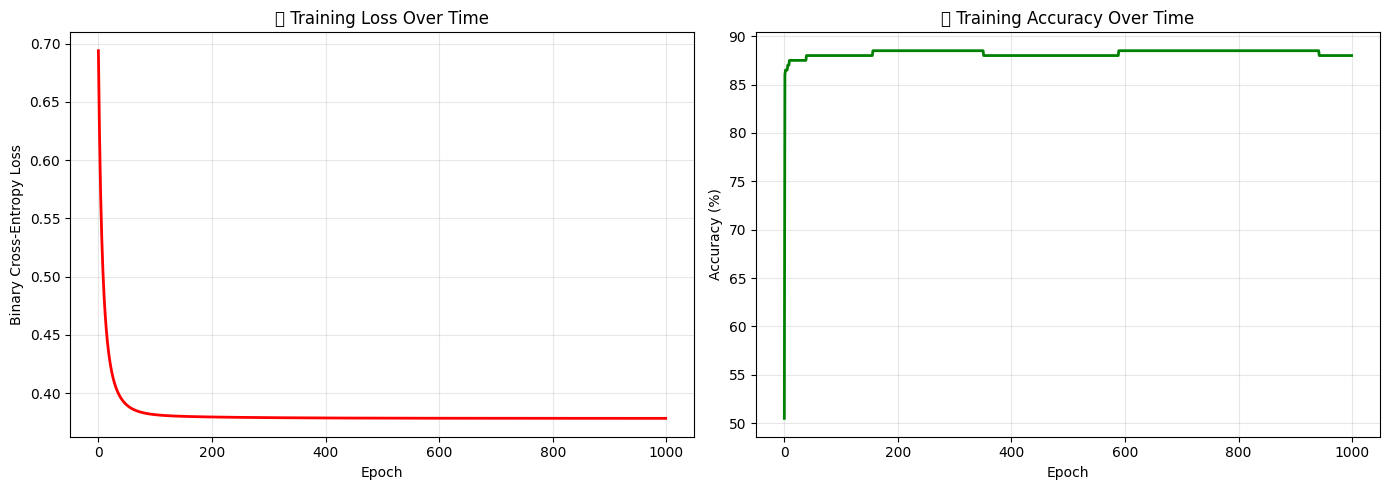

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(model.losses, color='red', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Binary Cross-Entropy Loss')
axes[0].set_title('📉 Training Loss Over Time')
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(model.accuracies, color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('📈 Training Accuracy Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 🔟 — Visualize Decision Boundary

The **decision boundary** is where the model's prediction probability equals 0.5.  
Let's visualize how our model separates the two classes.

/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


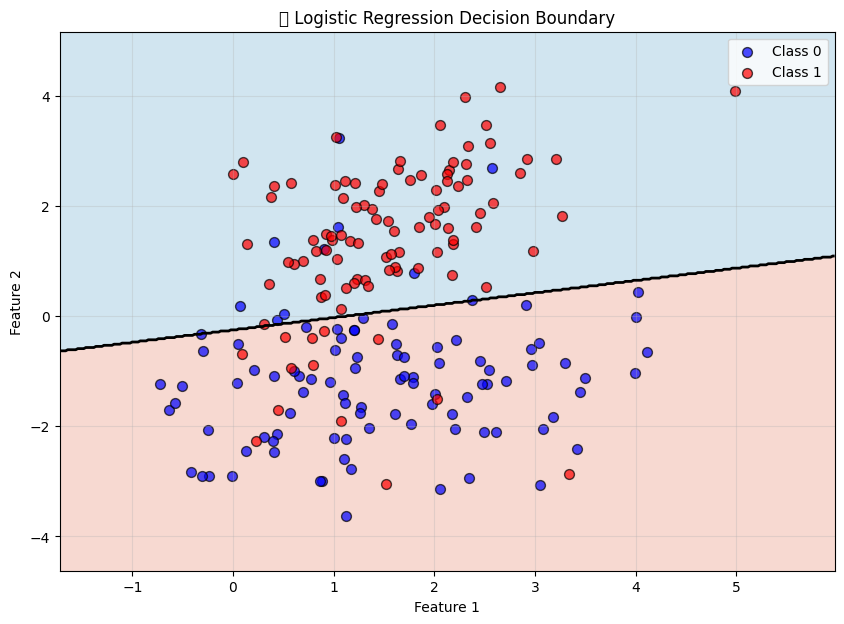

In [27]:
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """Plot decision boundary for 2D dataset"""
    
    # Create mesh
    h = 0.02  # step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdBu', levels=[0, 0.5, 1])
    plt.contour(xx, yy, Z, colors='black', linewidths=2, levels=[0.5])
    
    # Plot data points
    plt.scatter(X[y.flatten() == 0, 0], X[y.flatten() == 0, 1],
                color='blue', label='Class 0', alpha=0.7, s=50, edgecolors='k')
    plt.scatter(X[y.flatten() == 1, 0], X[y.flatten() == 1, 1],
                color='red', label='Class 1', alpha=0.7, s=50, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot decision boundary
plot_decision_boundary(model, X, y, 
                      title="🎯 Logistic Regression Decision Boundary")

### Step 1️⃣1️⃣ — Benchmark Against Scikit-Learn

Now let's compare our implementation with the industry-standard sklearn implementation.

We'll compare:
1. **Accuracy** — How well do predictions match?
2. **Training time** — Speed comparison
3. **Learned parameters** — Are weights similar?

In [28]:
from sklearn.linear_model import LogisticRegression as SklearnLogReg
from sklearn.metrics import accuracy_score, classification_report
import time

# Train sklearn model
print("Training scikit-learn Logistic Regression...")
start_time = time.time()

sklearn_model = SklearnLogReg(random_state=42, max_iter=1000)
sklearn_model.fit(X, y.ravel())

sklearn_time = time.time() - start_time
sklearn_pred = sklearn_model.predict(X)
sklearn_acc = accuracy_score(y, sklearn_pred) * 100

print(f"✅ Sklearn training time: {sklearn_time:.4f} seconds")
print(f"✅ Sklearn accuracy: {sklearn_acc:.2f}%")

# Train our model with timing
print("\nTraining our custom Logistic Regression...")
start_time = time.time()

our_model = LogisticRegression(n_features=2, lr=0.1)
our_model.fit(X, y, epochs=1000, verbose=False)

our_time = time.time() - start_time
our_pred = our_model.predict(X)
our_acc = our_model.compute_accuracy(our_model.forward(X), y)

print(f"✅ Our training time: {our_time:.4f} seconds")
print(f"✅ Our accuracy: {our_acc:.2f}%")

Training scikit-learn Logistic Regression...
✅ Sklearn training time: 0.0090 seconds
✅ Sklearn accuracy: 88.00%

Training our custom Logistic Regression...
✅ Our training time: 0.2433 seconds
✅ Our accuracy: 88.00%


### Step 1️⃣2️⃣ — Detailed Comparison

In [29]:
print("=" * 60)
print("📊 BENCHMARK RESULTS")
print("=" * 60)
print(f"\n{'Metric':<30} {'Our Model':<15} {'Sklearn':<15}")
print("-" * 60)
print(f"{'Training Time (seconds)':<30} {our_time:<15.4f} {sklearn_time:<15.4f}")
print(f"{'Final Accuracy (%)':<30} {our_acc:<15.2f} {sklearn_acc:<15.2f}")
print(f"{'Final Loss':<30} {model.losses[-1]:<15.4f} {'N/A':<15}")
print()

# Compare weights
print("Learned Weights:")
print(f"Our Model W: {our_model.W.flatten()}")
print(f"Sklearn W:   {sklearn_model.coef_.flatten()}")
print()
print(f"Our Model b: {our_model.b.flatten()}")
print(f"Sklearn b:   {sklearn_model.intercept_}")
print("=" * 60)

📊 BENCHMARK RESULTS

Metric                         Our Model       Sklearn        
------------------------------------------------------------
Training Time (seconds)        0.2433          0.0090         
Final Accuracy (%)             88.00           88.00          
Final Loss                     0.3783          N/A            

Learned Weights:
Our Model W: [-0.29618446  1.32148455]
Sklearn W:   [-0.28485969  1.28497906]

Our Model b: [0.33433338]
Sklearn b:   [0.32495406]


## Part 2: Extending to Multi-Class Classification

### Step 1️⃣3️⃣ — From Binary to Multi-Class: Enter Softmax

So far, we've mastered **binary classification** (2 classes: 0 or 1).  
But what if we have **more than 2 classes**?

- Classifying handwritten digits (0-9) → **10 classes**
- Recognizing animals (cat, dog, bird) → **3 classes**
- Sentiment analysis (positive, neutral, negative) → **3 classes**

> *"Sigmoid gives us one probability. Softmax gives us a probability distribution over all classes."*

### 🤔 The Problem with Binary Approach

For binary classification:
- Sigmoid outputs: $P(y=1)$
- We get $P(y=0) = 1 - P(y=1)$ for free

For 3+ classes, we need:
- $P(y=\text{class}_0), P(y=\text{class}_1), ..., P(y=\text{class}_k)$
- All probabilities must sum to 1

**Softmax solves this!**

### Step 1️⃣4️⃣ — The Softmax Function (Motivated)

Softmax generalizes the sigmoid to **multiple classes**. While sigmoid outputs a probability for **one class** in binary classification, softmax handles **K classes** simultaneously.

---

#### 1️⃣ Motivation

- Suppose we have **K linear scores** \(z_1, z_2, ..., z_K\) for a single input.  
- We want a function that:
  1. Converts **arbitrary real numbers** into probabilities between 0 and 1
  2. Ensures **all probabilities sum to 1**
  3. Gives **higher probability to larger scores**  

This is exactly what **Softmax** does:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

---

#### 2️⃣ Properties & Insights

- **Range:** Each output \(\in (0,1)\) → valid probability  
- **Sum-to-one:** \(\sum_{i=1}^{K} \text{Softmax}(z_i) = 1\) → can be interpreted as a distribution  
- **Monotonic:** Larger \(z_i\) → larger probability  
- **Differentiable:** Perfect for gradient-based optimization  

> ⚡ Special Case: \(K=2\) → softmax reduces to sigmoid

---

#### 3️⃣ Numerical Stability Trick

- Exponentials can **explode** for large \(z\) values → overflow  
- Subtract the maximum score per row: \(z_{\text{stable}} = z - \max(z)\)  
- This doesn’t change the probabilities:

$$
\frac{e^{z_i}}{\sum_j e^{z_j}} = \frac{e^{z_i - z_{\max}}}{\sum_j e^{z_j - z_{\max}}}
$$



#### 4️⃣ Python Implementation & Visualization

In [33]:

import numpy as np
import matplotlib.pyplot as plt

def softmax(z):
    """
    Softmax activation function
    
    Args:
        z: linear outputs (m, K) where K is number of classes
    
    Returns:
        probabilities: (m, K) with each row summing to 1
    """
    z_stable = z - np.max(z, axis=1, keepdims=True)  # numerical stability
    exp_z = np.exp(z_stable)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# --- Example linear outputs for 3 classes ---
z_example = np.array([
    [2.0, 1.0, 0.1],   # Class 0 most likely
    [0.5, 2.5, 0.3],   # Class 1 most likely
    [0.2, 0.3, 3.0]    # Class 2 most likely
])

# Compute softmax probabilities
probs = softmax(z_example)

# Print raw scores and probabilities
for i, z in enumerate(z_example):
    print(f"Example {i+1}:")
    print("Raw scores (z):", z)
    print("Softmax probabilities:", probs[i])
    print("Sum of probabilities:", probs[i].sum())
    print("-"*50)



Example 1:
Raw scores (z): [2.  1.  0.1]
Softmax probabilities: [0.65900114 0.24243297 0.09856589]
Sum of probabilities: 1.0
--------------------------------------------------
Example 2:
Raw scores (z): [0.5 2.5 0.3]
Softmax probabilities: [0.10860373 0.80247906 0.08891721]
Sum of probabilities: 0.9999999999999999
--------------------------------------------------
Example 3:
Raw scores (z): [0.2 0.3 3. ]
Softmax probabilities: [0.05390889 0.05957853 0.88651258]
Sum of probabilities: 1.0
--------------------------------------------------


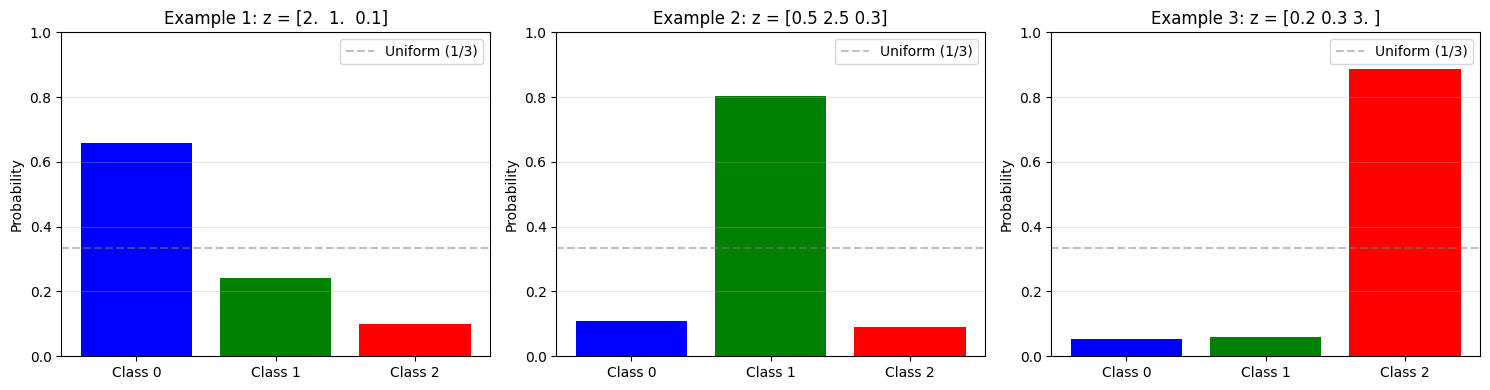

Softmax outputs (each row sums to 1):
[[0.65900114 0.24243297 0.09856589]
 [0.10860373 0.80247906 0.08891721]
 [0.05390889 0.05957853 0.88651258]]

Row sums: [1. 1. 1.]


In [34]:


# Plot probabilities
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['blue', 'green', 'red']
class_names = ['Class 0', 'Class 1', 'Class 2']

for i in range(3):
    axes[i].bar(class_names, probs[i], color=colors)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('Probability')
    axes[i].set_title(f'Example {i+1}: z = {z_example[i]}')
    axes[i].grid(True, alpha=0.3, axis='y')
    axes[i].axhline(y=1/3, color='gray', linestyle='--', alpha=0.5, label='Uniform (1/3)')
    axes[i].legend()

plt.tight_layout()
plt.show()

print("Softmax outputs (each row sums to 1):")
print(probs)
print(f"\nRow sums: {probs.sum(axis=1)}")

### Step 1️⃣5️⃣ — Multi-Class Loss: Categorical Cross-Entropy (Motivated)

#### 1️⃣ Binary Cross-Entropy Recap

For binary classification, with a single probability $\hat{y}$ for class 1:

$$
\text{BCE} = -\frac{1}{m}\sum_{i=1}^{m} \Big[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)\Big]
$$

- $y_i = 0$ or $1$  
- Penalizes the model if it assigns **low probability to the true class**  
- Works perfectly with **sigmoid outputs**, which produce a probability for class 1  

---

#### 2️⃣ One-Hot Encoding View

We can rewrite binary labels as **one-hot vectors** with 2 classes:

- True class 0 → $y = [1,0]$  
- True class 1 → $y = [0,1]$  

Let $\hat{y} = [\hat{y}_0, \hat{y}_1]$ be predicted probabilities (sum to 1). Then BCE becomes:

$$
\text{BCE} = - \frac{1}{m} \sum_{i=1}^{m} \Big[ y_{i0} \log(\hat{y}_{i0}) + y_{i1} \log(\hat{y}_{i1}) \Big]
$$

✅ Notice that **this is exactly the same as the categorical cross-entropy formula** for $K=2$!

---

#### 3️⃣ Generalizing to Multi-Class

- For $K$ classes, we have one-hot labels:

$$
y_i = [0, 0, 1, 0] \quad (\text{true class 2})
$$

- Predicted probabilities from softmax:

$$
\hat{y}_i = [0.1, 0.2, 0.6, 0.1]
$$

- Loss is:

$$
\text{CCE} = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_{ik} \log(\hat{y}_{ik})
$$

- Only the **true class contributes**, because one-hot labels are 0 for all other classes:

$$
\text{CCE} = -\frac{1}{m} \sum_{i=1}^{m} \log(\hat{y}_{i, \text{true class}})
$$

> 🔹 Intuition: We only **penalize the model for the probability it assigned to the correct class**, ignoring all others.

---

#### 4️⃣ Why BCE → CCE

1. Binary case: 2 classes → one-hot vector → same formula  
2. Multi-class: $K$ classes → same formula **generalized**  
3. Softmax ensures probabilities sum to 1 → combined with CCE, the model is **encouraged to assign all probability mass to the correct class**

---

#### 5️⃣ Numerical Example



In [36]:


# Suppose 3-class problem, one example
y_true = np.array([0, 0, 1])       # class 2
y_pred = np.array([0.2, 0.3, 0.5]) # predicted probabilities

# Categorical cross-entropy
cce = -np.sum(y_true * np.log(y_pred))
print("Categorical Cross-Entropy:", cce)

Categorical Cross-Entropy: 0.6931471805599453


/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


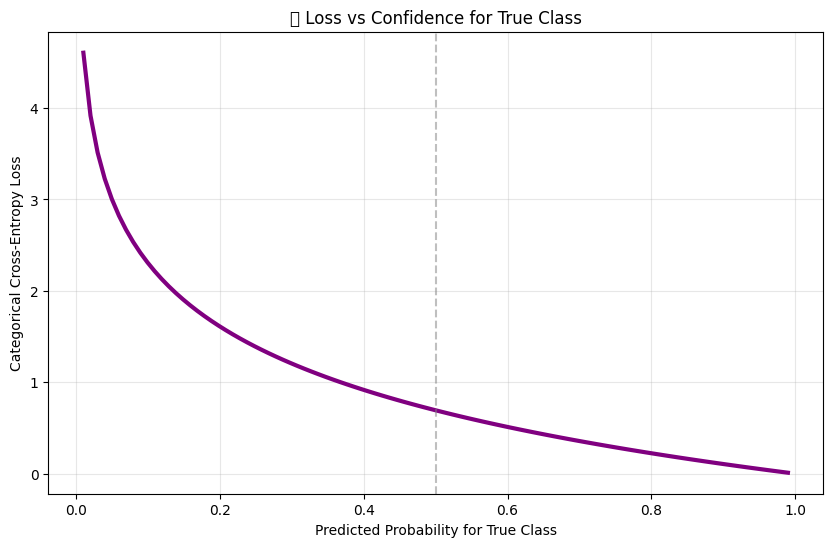

In [37]:
# Visualize categorical cross-entropy
pred_probs = np.linspace(0.01, 0.99, 100)
loss = -np.log(pred_probs)

plt.figure(figsize=(10, 6))
plt.plot(pred_probs, loss, linewidth=3, color='purple')
plt.xlabel('Predicted Probability for True Class')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.title('📊 Loss vs Confidence for True Class')
plt.grid(True, alpha=0.3)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
plt.show()


In [38]:
print("Loss examples:")
print(f"Predicted 0.99 for true class → Loss: {-np.log(0.99):.4f} ✅ (very good)")
print(f"Predicted 0.50 for true class → Loss: {-np.log(0.50):.4f} 😐 (uncertain)")
print(f"Predicted 0.01 for true class → Loss: {-np.log(0.01):.4f} ❌ (very bad!)")

Loss examples:
Predicted 0.99 for true class → Loss: 0.0101 ✅ (very good)
Predicted 0.50 for true class → Loss: 0.6931 😐 (uncertain)
Predicted 0.01 for true class → Loss: 4.6052 ❌ (very bad!)


### Step 1️⃣6️⃣ — Gradients for Softmax Regression

For **multi-class classification** using softmax and categorical cross-entropy (CCE), the gradients are surprisingly **simple and elegant** — just like in binary logistic regression.

---

#### 1️⃣ Gradient w.r.t. weights \(W\)

$$
\frac{\partial \text{CCE}}{\partial \mathbf{W}} = \frac{1}{m} \mathbf{X}^T (\hat{y} - y)
$$

Where:

- $\mathbf{X}$: input features (m, n)  
- $\hat{y}$: predicted probabilities from softmax (m, K)  
- $y$: one-hot encoded true labels (m, K)  
- $m$: number of examples  

> 💡 **Intuition:**  
> - Each column of $\mathbf{X}^T$ accumulates the **error for each feature** across all examples  
> - The term $(\hat{y} - y)$ measures **how far the predicted probabilities are from the true labels**  
> - This is exactly analogous to the **binary case**, just generalized to multiple classes  

---

#### 2️⃣ Gradient w.r.t. bias \(b\)

$$
\frac{\partial \text{CCE}}{\partial \mathbf{b}} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)
$$

- For each class \(k\), sum the errors over all examples  
- This gives a vector of size \(K\), one bias per class  

---

#### 3️⃣ Why it’s so simple

1. Softmax outputs sum to 1 → derivative of log probability cancels terms nicely  
2. CCE derivative with respect to logits \((z = XW+b)\) combines with softmax derivative → **no messy factors**  
3. Result: gradient formula is identical in **form** to linear regression and binary logistic regression  

> ✅ This is why deep learning frameworks implement **softmax + categorical cross-entropy in one combined function** — it’s numerically stable and efficient!

### Step 1️⃣7️⃣ — Create Multi-Class Dataset

Let's create a 3-class classification problem we can visualize.

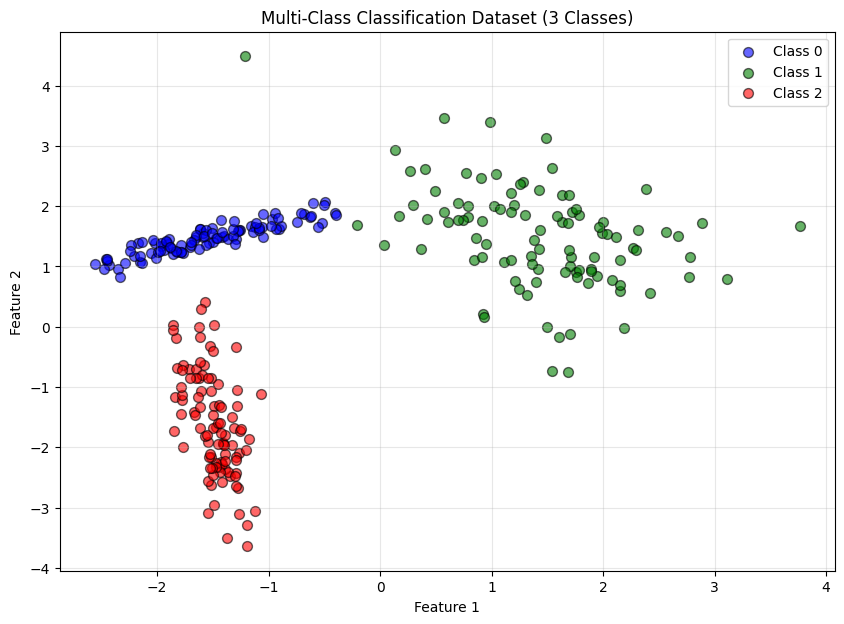

Dataset shape: X (300, 2), y (300,)
Class distribution: [100 100 100]


In [42]:
# Generate 3-class dataset
np.random.seed(42)
X_multi, y_multi = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=3,
    class_sep=1.5,
    random_state=42
)

# Visualize
plt.figure(figsize=(10, 7))
colors = ['blue', 'green', 'red']
class_names = ['Class 0', 'Class 1', 'Class 2']

for i, (color, name) in enumerate(zip(colors, class_names)):
    mask = y_multi == i
    plt.scatter(X_multi[mask, 0], X_multi[mask, 1], 
                c=color, label=name, alpha=0.6, s=50, edgecolors='k')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Multi-Class Classification Dataset (3 Classes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset shape: X {X_multi.shape}, y {y_multi.shape}")
print(f"Class distribution: {np.bincount(y_multi)}")

### Step 1️⃣8️⃣ — Implement Softmax Regression Class

In [79]:
class SoftmaxRegression:
    def __init__(self, n_features, n_classes, lr=0.01):
        """
        Initialize Softmax Regression model
        """
        self.n_classes = n_classes
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros((1, n_classes))
        self.lr = lr
        self.losses = []
        self.accuracies = []

    def softmax(self, z):
        """Softmax activation function"""
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        """Compute class probabilities"""
        return self.softmax(X @ self.W + self.b)

    def compute_loss(self, y_pred, y_true):
        """Categorical Cross-Entropy loss"""
        y_pred = np.clip(y_pred, 1e-7, 1-1e-7)
        if y_true.ndim == 1:  # integer labels → convert to one-hot
            y_true = np.eye(self.n_classes)[y_true]
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def compute_accuracy(self, y_pred, y_true):
        """Classification accuracy"""
        pred_classes = np.argmax(y_pred, axis=1)
        if y_true.ndim == 2:  # one-hot
            true_classes = np.argmax(y_true, axis=1)
        else:  # integer labels
            true_classes = y_true
        return np.mean(pred_classes == true_classes) * 100

    def backward(self, X, y_pred, y_true):
        """Compute gradients"""
        if y_true.ndim == 1:
            y_true = np.eye(self.n_classes)[y_true]
        m = len(y_true)
        dW = (1/m) * X.T @ (y_pred - y_true)
        db = (1/m) * np.sum(y_pred - y_true, axis=0, keepdims=True)
        return dW, db

    def step(self, dW, db):
        """Update weights and biases"""
        self.W -= self.lr * dW
        self.b -= self.lr * db

    def fit(self, X, y, epochs=1000, verbose=True):
        """Train the model"""
        for i in range(epochs):
            y_pred = self.forward(X)
            loss = self.compute_loss(y_pred, y)
            acc = self.compute_accuracy(y_pred, y)
            self.losses.append(loss)
            self.accuracies.append(acc)
            dW, db = self.backward(X, y_pred, y)
            self.step(dW, db)
            if verbose and (i % 100 == 0 or i == epochs - 1):
                print(f"Epoch {i:4d} | Loss: {loss:.4f} | Accuracy: {acc:.2f}%")

    def predict(self, X):
        """Predict class labels"""
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

    def predict_proba(self, X):
        """Predict class probabilities"""
        return self.forward(X)


### Step 1️⃣9️⃣ — Train Softmax Regression Model

In [80]:
# Create and train model
softmax_model = SoftmaxRegression(n_features=2, n_classes=3, lr=0.1)
softmax_model.fit(X_multi, y_multi, epochs=1000, verbose=True)

print("\n✅ Training Complete!")
print(f"Final Loss: {softmax_model.losses[-1]:.4f}")
print(f"Final Accuracy: {softmax_model.accuracies[-1]:.2f}%")

Epoch    0 | Loss: 1.1143 | Accuracy: 0.00%
Epoch  100 | Loss: 0.1314 | Accuracy: 98.67%
Epoch  200 | Loss: 0.0945 | Accuracy: 98.67%
Epoch  300 | Loss: 0.0793 | Accuracy: 98.67%
Epoch  400 | Loss: 0.0707 | Accuracy: 98.67%
Epoch  500 | Loss: 0.0649 | Accuracy: 98.67%
Epoch  600 | Loss: 0.0607 | Accuracy: 99.00%
Epoch  700 | Loss: 0.0575 | Accuracy: 99.00%
Epoch  800 | Loss: 0.0549 | Accuracy: 99.00%
Epoch  900 | Loss: 0.0528 | Accuracy: 99.33%
Epoch  999 | Loss: 0.0511 | Accuracy: 99.33%

✅ Training Complete!
Final Loss: 0.0511
Final Accuracy: 99.33%


### Step 2️⃣0️⃣ — Visualize Multi-Class Decision Boundaries

/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


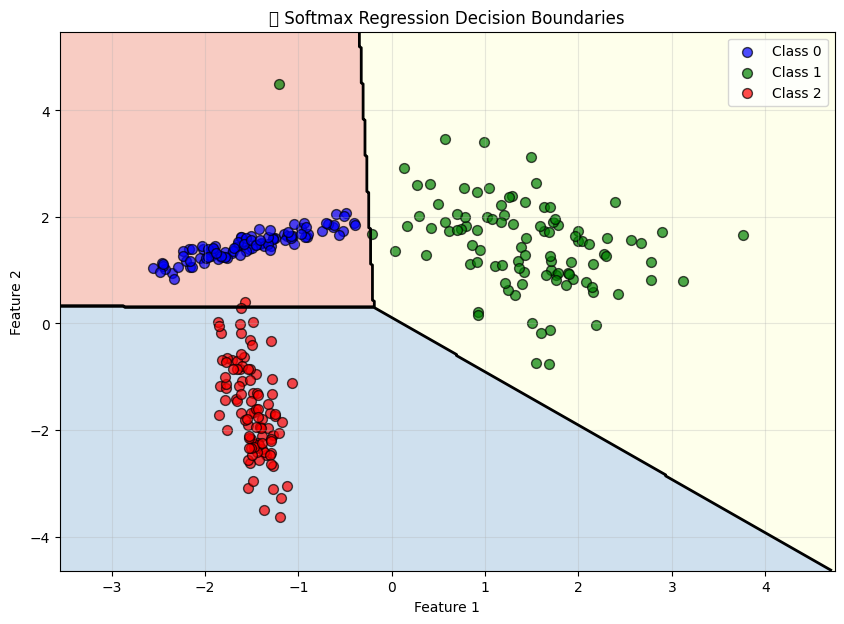

In [81]:
def plot_multiclass_decision_boundary(model, X, y, title="Decision Boundaries"):
    """Plot decision boundaries for multi-class classification"""
    
    # Create mesh
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 7))
    
    # Decision regions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=np.arange(4)-0.5)
    
    # Decision boundaries
    plt.contour(xx, yy, Z, colors='black', linewidths=2, levels=np.arange(3)-0.5)
    
    # Plot data points
    colors = ['blue', 'green', 'red']
    class_names = ['Class 0', 'Class 1', 'Class 2']
    
    for i, (color, name) in enumerate(zip(colors, class_names)):
        mask = y == i
        plt.scatter(X[mask, 0], X[mask, 1],
                   c=color, label=name, alpha=0.7, s=50, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot decision boundaries
plot_multiclass_decision_boundary(softmax_model, X_multi, y_multi,
                                 title="🎯 Softmax Regression Decision Boundaries")

### Step 2️⃣1️⃣ — Benchmark Against Scikit-Learn (Multi-Class)

In [82]:
# Train sklearn model (uses softmax for multi-class)
print("Training scikit-learn Logistic Regression (multi-class)...")
start_time = time.time()

sklearn_multi = SklearnLogReg(multi_class='multinomial', random_state=42, max_iter=1000)
sklearn_multi.fit(X_multi, y_multi)

sklearn_time = time.time() - start_time
sklearn_pred = sklearn_multi.predict(X_multi)
sklearn_acc = accuracy_score(y_multi, sklearn_pred) * 100

print(f"✅ Sklearn training time: {sklearn_time:.4f} seconds")
print(f"✅ Sklearn accuracy: {sklearn_acc:.2f}%")

# Our model
print("\nTraining our custom Softmax Regression...")
start_time = time.time()

our_multi_model = SoftmaxRegression(n_features=2, n_classes=3, lr=0.1)
our_multi_model.fit(X_multi, y_multi, epochs=1000, verbose=False)

our_time = time.time() - start_time
our_pred = our_multi_model.predict(X_multi)
our_acc = accuracy_score(y_multi, our_pred) * 100

print(f"✅ Our training time: {our_time:.4f} seconds")
print(f"✅ Our accuracy: {our_acc:.2f}%")

# Comparison
print("\n" + "=" * 60)
print("📊 MULTI-CLASS BENCHMARK RESULTS")
print("=" * 60)
print(f"\n{'Metric':<30} {'Our Model':<15} {'Sklearn':<15}")
print("-" * 60)
print(f"{'Training Time (seconds)':<30} {our_time:<15.4f} {sklearn_time:<15.4f}")
print(f"{'Final Accuracy (%)':<30} {our_acc:<15.2f} {sklearn_acc:<15.2f}")
print("=" * 60)

Training scikit-learn Logistic Regression (multi-class)...
✅ Sklearn training time: 0.0306 seconds
✅ Sklearn accuracy: 99.33%

Training our custom Softmax Regression...


/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Our training time: 0.5228 seconds
✅ Our accuracy: 99.33%

📊 MULTI-CLASS BENCHMARK RESULTS

Metric                         Our Model       Sklearn        
------------------------------------------------------------
Training Time (seconds)        0.5228          0.0306         
Final Accuracy (%)             99.33           99.33          


## Part 3: Applications


### Step 2️⃣3️⃣ — Simple Example: Iris Dataset (3 Classes)

Let's apply our softmax regression to the classic Iris dataset.

In [91]:
from sklearn.datasets import load_iris


# Load iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target


print("📊 Iris Dataset Information:")
print(f"Features: {iris.feature_names}")
print(f"Classes: {iris.target_names}")
print(f"Samples: {len(X_iris)}")
print(f"Class distribution: {np.bincount(y_iris)}")

# Dimensions of the dataset
print(f"\nFeature matrix shape (X): {X_iris.shape}")
print(f"Target vector shape (y): {y_iris.shape}")


📊 Iris Dataset Information:
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
Samples: 150
Class distribution: [50 50 50]

Feature matrix shape (X): (150, 4)
Target vector shape (y): (150,)


## For fun (and reminder) lets scale with no standard scaler 

In [110]:
# --- 2️⃣ Manual train/test split (70/30) ---
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)

split_idx = int(0.7 * len(X))
train_idx = indices[:split_idx]
test_idx = indices[split_idx:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# --- 3️⃣ Manual standardization ---
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std


Train set: (105, 4)
Test set: (45, 4)


## Training and evaluation remains the same as before. 
## for experimentation purposes lets train with and without standard scaler

Epoch    0 | Loss: 1.1118 | Accuracy: 38.10%
Epoch  100 | Loss: 0.3931 | Accuracy: 80.00%
Epoch  200 | Loss: 0.2651 | Accuracy: 97.14%
Epoch  300 | Loss: 0.2238 | Accuracy: 97.14%
Epoch  400 | Loss: 0.1976 | Accuracy: 97.14%
Epoch  500 | Loss: 0.1794 | Accuracy: 97.14%
Epoch  600 | Loss: 0.1659 | Accuracy: 97.14%
Epoch  700 | Loss: 0.1556 | Accuracy: 97.14%
Epoch  800 | Loss: 0.1474 | Accuracy: 97.14%
Epoch  900 | Loss: 0.1407 | Accuracy: 97.14%
Epoch 1000 | Loss: 0.1351 | Accuracy: 97.14%
Epoch 1100 | Loss: 0.1303 | Accuracy: 97.14%
Epoch 1200 | Loss: 0.1263 | Accuracy: 97.14%
Epoch 1300 | Loss: 0.1227 | Accuracy: 97.14%
Epoch 1400 | Loss: 0.1196 | Accuracy: 97.14%
Epoch 1500 | Loss: 0.1168 | Accuracy: 97.14%
Epoch 1600 | Loss: 0.1143 | Accuracy: 97.14%
Epoch 1700 | Loss: 0.1121 | Accuracy: 97.14%
Epoch 1800 | Loss: 0.1100 | Accuracy: 97.14%
Epoch 1900 | Loss: 0.1082 | Accuracy: 97.14%
Epoch 1999 | Loss: 0.1065 | Accuracy: 97.14%

🎯 Test Accuracy: 97.78%


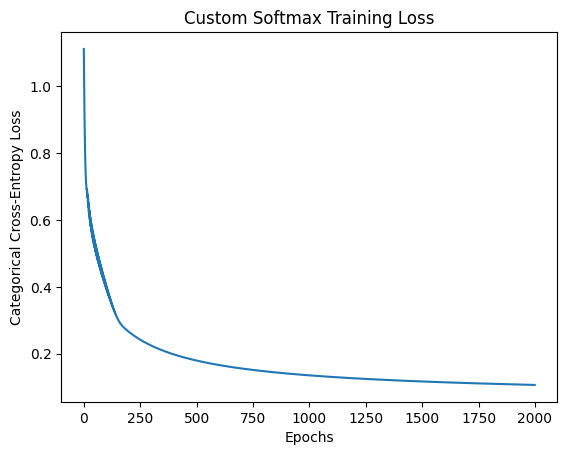

In [114]:
# --- 4️⃣ Initialize SoftmaxRegression ---
n_features = X_train.shape[1]  # 4 features in Iris
n_classes = len(np.unique(y_iris))  # 3 classes

iris_model = SoftmaxRegression(n_features=n_features, n_classes=n_classes, lr=0.1)
iris_model.fit(X_train, y_train, epochs=2000, verbose=True)

y_pred = iris_model.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"\n🎯 Test Accuracy: {accuracy:.2f}%")

# --- 7️⃣ Plot training loss for custom model ---
plt.plot(iris_model.losses)
plt.xlabel("Epochs")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Custom Softmax Training Loss")
plt.show()

Epoch    0 | Loss: 1.1143 | Accuracy: 22.86%
Epoch  100 | Loss: 0.3202 | Accuracy: 88.57%
Epoch  200 | Loss: 0.2614 | Accuracy: 90.48%
Epoch  300 | Loss: 0.2262 | Accuracy: 92.38%
Epoch  400 | Loss: 0.2017 | Accuracy: 94.29%
Epoch  500 | Loss: 0.1835 | Accuracy: 95.24%
Epoch  600 | Loss: 0.1696 | Accuracy: 94.29%
Epoch  700 | Loss: 0.1586 | Accuracy: 94.29%
Epoch  800 | Loss: 0.1497 | Accuracy: 94.29%
Epoch  900 | Loss: 0.1423 | Accuracy: 94.29%
Epoch 1000 | Loss: 0.1361 | Accuracy: 94.29%
Epoch 1100 | Loss: 0.1308 | Accuracy: 95.24%
Epoch 1200 | Loss: 0.1262 | Accuracy: 95.24%
Epoch 1300 | Loss: 0.1221 | Accuracy: 95.24%
Epoch 1400 | Loss: 0.1186 | Accuracy: 96.19%
Epoch 1500 | Loss: 0.1154 | Accuracy: 96.19%
Epoch 1600 | Loss: 0.1126 | Accuracy: 96.19%
Epoch 1700 | Loss: 0.1100 | Accuracy: 96.19%
Epoch 1800 | Loss: 0.1077 | Accuracy: 96.19%
Epoch 1900 | Loss: 0.1056 | Accuracy: 96.19%
Epoch 1999 | Loss: 0.1036 | Accuracy: 96.19%

🎯 Test Accuracy: 100.00%


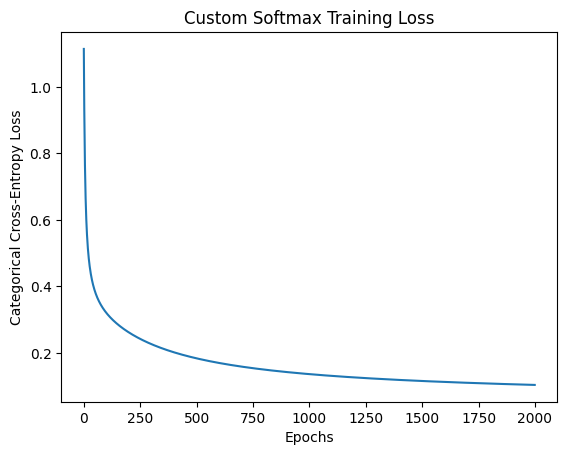

In [115]:
# --- 4️⃣ Initialize SoftmaxRegression ---
n_features = X_train.shape[1]  # 4 features in Iris
n_classes = len(np.unique(y_iris))  # 3 classes

iris_model = SoftmaxRegression(n_features=n_features, n_classes=n_classes, lr=0.1)
iris_model.fit(X_train_scaled, y_train, epochs=2000, verbose=True)

y_pred = iris_model.predict(X_test_scaled)
accuracy = np.mean(y_pred == y_test) * 100
print(f"\n🎯 Test Accuracy: {accuracy:.2f}%")

# --- 7️⃣ Plot training loss for custom model ---
plt.plot(iris_model.losses)
plt.xlabel("Epochs")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Custom Softmax Training Loss")
plt.show()

📊 Iris Dataset Information:
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
Samples: 150
Class distribution: [50 50 50]
Epoch    0 | Loss: 1.0846 | Accuracy: 73.33%
Epoch  100 | Loss: 0.6311 | Accuracy: 85.71%
Epoch  200 | Loss: 0.5047 | Accuracy: 87.62%
Epoch  300 | Loss: 0.4429 | Accuracy: 86.67%
Epoch  400 | Loss: 0.4043 | Accuracy: 88.57%
Epoch  500 | Loss: 0.3771 | Accuracy: 90.48%
Epoch  600 | Loss: 0.3564 | Accuracy: 90.48%


Epoch  700 | Loss: 0.3398 | Accuracy: 90.48%
Epoch  800 | Loss: 0.3260 | Accuracy: 92.38%
Epoch  900 | Loss: 0.3142 | Accuracy: 92.38%
Epoch 1000 | Loss: 0.3038 | Accuracy: 93.33%
Epoch 1100 | Loss: 0.2946 | Accuracy: 93.33%
Epoch 1200 | Loss: 0.2863 | Accuracy: 93.33%
Epoch 1300 | Loss: 0.2787 | Accuracy: 93.33%
Epoch 1400 | Loss: 0.2717 | Accuracy: 93.33%
Epoch 1500 | Loss: 0.2652 | Accuracy: 93.33%
Epoch 1600 | Loss: 0.2592 | Accuracy: 94.29%
Epoch 1700 | Loss: 0.2535 | Accuracy: 94.29%
Epoch 1800 | Loss: 0.2481 | Accuracy: 95.24%
Epoch 1900 | Loss: 0.2431 | Accuracy: 95.24%
Epoch 1999 | Loss: 0.2383 | Accuracy: 95.24%

🎯 Custom Softmax Test Accuracy: 84.44%

📊 Classification Report (Custom Softmax):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      0.73      0.76        15
   virginica       0.75      0.80      0.77        15

    accuracy                           0.84        45
   macro avg   

/home/silva/SILVA.AI/Projects/SAIR/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


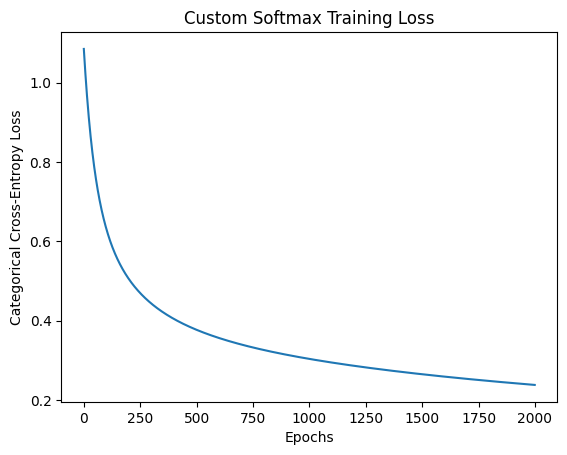

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 1️⃣ Load Iris dataset ---
iris = load_iris()
X = iris.data
y = iris.target

print("📊 Iris Dataset Information:")
print(f"Features: {iris.feature_names}")
print(f"Classes: {iris.target_names}")
print(f"Samples: {len(X)}")
print(f"Class distribution: {np.bincount(y)}")

# --- 2️⃣ Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- 3️⃣ Standardize features ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 4️⃣ Train custom SoftmaxRegression ---
n_features = X_train.shape[1]
n_classes = len(np.unique(y))
iris_model = SoftmaxRegression(n_features=n_features, n_classes=n_classes, lr=0.01)

iris_model.fit(X_train, y_train, epochs=2000, verbose=True)

# --- 5️⃣ Evaluate custom model ---
y_pred_custom = iris_model.predict(X_test)
acc_custom = accuracy_score(y_test, y_pred_custom) * 100
print(f"\n🎯 Custom Softmax Test Accuracy: {acc_custom:.2f}%")

print("\n📊 Classification Report (Custom Softmax):")
print(classification_report(y_test, y_pred_custom, target_names=iris.target_names))

cm_custom = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix (Custom Softmax):\n", cm_custom)

# --- 6️⃣ Train scikit-learn LogisticRegression ---
sk_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
sk_model.fit(X_train, y_train)

y_pred_sk = sk_model.predict(X_test)
acc_sk = accuracy_score(y_test, y_pred_sk) * 100
print(f"\n🎯 scikit-learn LogisticRegression Test Accuracy: {acc_sk:.2f}%")

print("\n📊 Classification Report (sklearn):")
print(classification_report(y_test, y_pred_sk, target_names=iris.target_names))

cm_sk = confusion_matrix(y_test, y_pred_sk)
print("Confusion Matrix (sklearn):\n", cm_sk)

# --- 7️⃣ Plot training loss for custom model ---
plt.plot(iris_model.losses)
plt.xlabel("Epochs")
plt.ylabel("Categorical Cross-Entropy Loss")
plt.title("Custom Softmax Training Loss")
plt.show()


## 📊 Model Evaluation: Classification Report & Confusion Matrix

After training a classification model, it is essential to evaluate its performance beyond simple accuracy. Two key tools for this are the **Classification Report** and the **Confusion Matrix**.

### 1️⃣ Classification Report

The **Classification Report** summarizes the performance of a classification model for each class. It typically includes:

- **Precision**  
  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
  $$  
  Measures how many of the predicted positive samples are actually correct.  
  High precision means few false positives.

- **Recall (Sensitivity)**  
  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
  $$  
  Measures how many of the actual positive samples are correctly identified.  
  High recall means few false negatives.

- **F1-score**  
  $$
  F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}
  $$  
  Harmonic mean of precision and recall, useful when classes are imbalanced.

- **Support**  
  The number of actual samples for each class.

The report helps us understand if the model is biased toward certain classes or if some classes are harder to predict.

---

### 2️⃣ Confusion Matrix

The **Confusion Matrix** is a table that shows the counts of correct and incorrect predictions for each class:

|               | Predicted Class A | Predicted Class B | ... |
|---------------|-----------------|-----------------|-----|
| **Actual A**  | True Positive   | False Negative  | ... |
| **Actual B**  | False Positive  | True Positive   | ... |
| ...           | ...             | ...             | ... |

- **Diagonal elements:** Correct predictions (True Positives for each class).  
- **Off-diagonal elements:** Misclassifications (False Positives and False Negatives).  

#### Why visualize it?

- Helps identify which classes are being confused by the model.  
- Useful for multi-class problems where accuracy alone may be misleading.  
- Colors and annotations make it easy to spot patterns in misclassification.

---

### ✅ Summary

By using both **Classification Report** and **Confusion Matrix**, we gain a **detailed view of our model's performance**:

- Accuracy gives a single number.  
- Classification report explains per-class behavior (precision, recall, F1).  
- Confusion matrix shows **exact counts of correct and incorrect predictions**, helping identify weaknesses.



📊 Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45


📊 Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  3 12]]


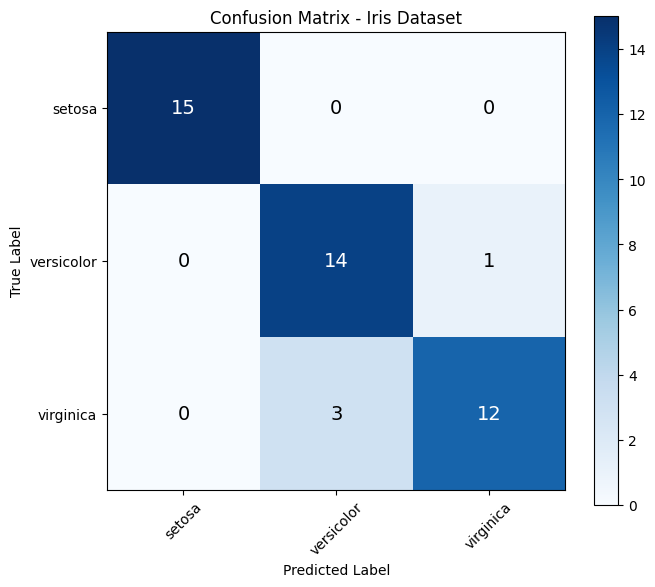

In [103]:

# --- 6️⃣ Classification report ---
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# --- 7️⃣ Confusion matrix ---
cm = confusion_matrix(y_test, y_pred)
print("\n📊 Confusion Matrix:")
print(cm)

# --- 8️⃣ Visualize confusion matrix ---
plt.figure(figsize=(7, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix - Iris Dataset")
plt.colorbar()
tick_marks = np.arange(len(iris.target_names))
plt.xticks(tick_marks, iris.target_names, rotation=45)
plt.yticks(tick_marks, iris.target_names)

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black',
                 fontsize=14)

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Feature importance 

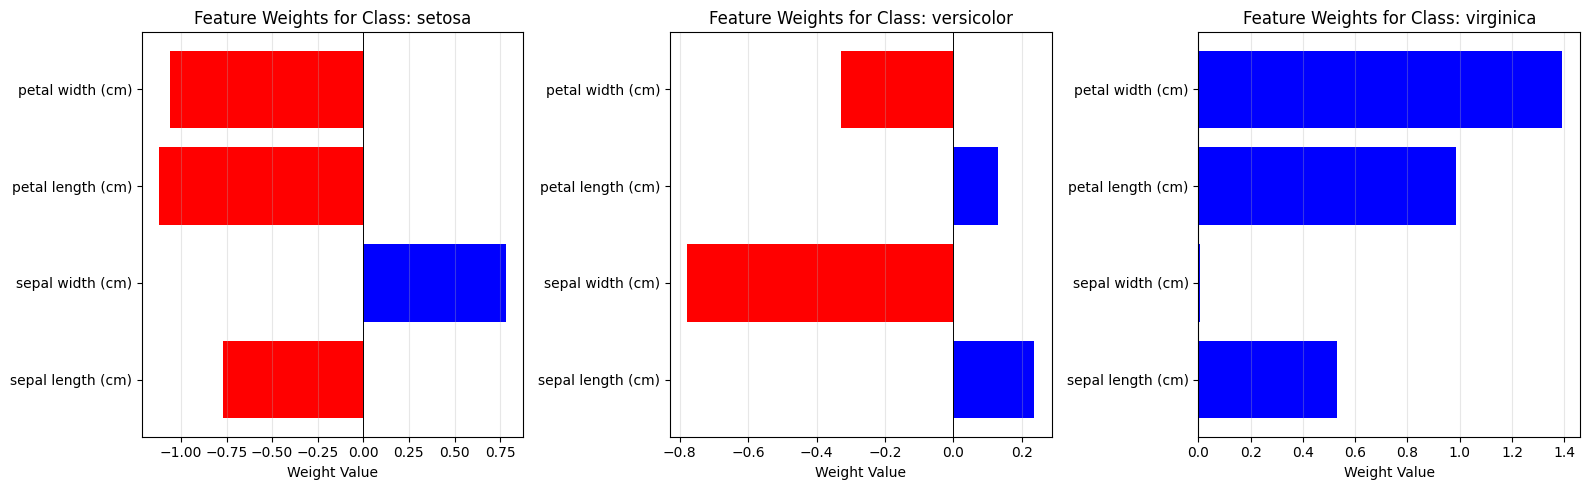

💡 Interpretation of Feature Weights:
• Blue bars: Positive weights → increase probability for this class
• Red bars: Negative weights → decrease probability for this class
• Magnitude: Larger absolute value → stronger influence on classification


In [104]:
# --- 1️⃣ Feature weights visualization for Iris dataset ---
feature_names_iris = iris.feature_names
class_names_iris = iris.target_names

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, (ax, class_name) in enumerate(zip(axes, class_names_iris)):
    weights = iris_model.W[:, i]
    colors = ['blue' if w >= 0 else 'red' for w in weights]
    
    ax.barh(feature_names_iris, weights, color=colors)
    ax.set_xlabel('Weight Value')
    ax.set_title(f'Feature Weights for Class: {class_name}')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.7)
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# --- 2️⃣ Interpretation ---
print("💡 Interpretation of Feature Weights:")
print("• Blue bars: Positive weights → increase probability for this class")
print("• Red bars: Negative weights → decrease probability for this class")
print("• Magnitude: Larger absolute value → stronger influence on classification")


## 📝 Final Note: From Notebook to Production Pipeline

### **Notebook vs Script**
- **Notebook (🖥️)**: Interactive, step-by-step exploration; great for visualization and experimentation.  
- **Script (⚙️)**: Modular, reusable, automated workflow; production-ready, consistent, and scalable.

---

### **The Power of Pipelines**
- Ensure **consistent preprocessing and modeling**  
- Prevent **data leakage**  
- Enable **repeatability & scalability**  
- Prepare workflows for **production deployment**

```mermaid
flowchart LR
    Data --> Preprocessing --> Model --> Evaluation --> Deployment
````

---

### **Enhanced Breast Cancer Pipeline**

* Logistic Regression with **GridSearchCV** hyperparameter tuning
* Tracks **training loss** for convergence
* Evaluates with: **Confusion Matrix, ROC Curve & AUC, Classification Report, Cross-Validation**
* Shows **feature importance** for interpretability

> 💡 **Tip:** After finishing the notebook, run `enhanced_breast_cancer_pipeline.py` to see the full production-ready pipeline in action.

---

### **Why This Matters**

* Bridges the gap between **experimentation and production**
* Highlights **performance, reproducibility & interpretability**
* Builds skills for **real-world ML systems**

```



## 🎯 Summary: Complete Classification Journey

Let's consolidate what we've learned about the evolution from regression to multi-class classification:

| Aspect | Linear Regression | Binary Logistic Regression | Multi-Class Softmax Regression |
|--------|------------------|---------------------|---------------------|
| **Task** | Regression (predict continuous values) | Binary Classification (2 classes) | Multi-Class Classification (3+ classes) |
| **Output** | Any real number $(-\infty, +\infty)$ | Probability $(0, 1)$ | Probability distribution over K classes |
| **Model** | $\hat{y} = \mathbf{X}\mathbf{W} + b$ | $\hat{y} = \sigma(\mathbf{X}\mathbf{W} + b)$ | $\hat{y} = \text{softmax}(\mathbf{X}\mathbf{W} + b)$ |
| **Activation** | None (linear) | Sigmoid: $\sigma(z) = 1/(1+e^{-z})$ | Softmax: $\text{softmax}(z_i) = e^{z_i} / \sum e^{z_j}$ |
| **Loss Function** | MSE: $\frac{1}{m}\sum(y - \hat{y})^2$ | BCE: $-\frac{1}{m}\sum[y\log(\hat{y}) + (1-y)\log(1-\hat{y})]$ | CCE: $-\frac{1}{m}\sum\sum y_{ik}\log(\hat{y}_{ik})$ |
| **Gradient** | $\frac{1}{m}\mathbf{X}^T(\hat{y} - y)$ | $\frac{1}{m}\mathbf{X}^T(\hat{y} - y)$ | $\frac{1}{m}\mathbf{X}^T(\hat{y} - y)$ |
| **Decision** | Direct prediction | Threshold at 0.5 | argmax(probabilities) |
| **Weights shape** | (n, 1) | (n, 1) | (n, K) |
| **Label encoding** | Continuous values | 0 or 1 | One-hot vectors |

### 🧠 Key Mathematical Insights:

1. **Elegant Gradient Forms**: All three models share the same gradient structure!
2. **Activation Functions**: Transform linear outputs to appropriate ranges
3. **Loss Functions**: Match the problem type (regression vs classification)
4. **Probability Interpretation**: Both sigmoid and softmax output valid probabilities

### 🚀 Path Forward:

This completes our foundation in **linear models**:
- ✅ Linear Regression (Lecture 1)
- ✅ Binary Classification (Sigmoid)
- ✅ Multi-Class Classification (Softmax)

**Next up:** Stack these building blocks into **Neural Networks**! but first, we will build a production-ready classification model.

---

*"Every deep neural network is just logistic/softmax regression... repeated many times with non-linear activations in between."*

## 🧠 Practice & Reflection — Complete Classification Journey

Congratulations 🎉 — you have successfully built both Binary and Multi-Class Logistic Regression from scratch, understood the mathematics behind them, and benchmarked against sklearn!

---

### 📌 **Part 1 — Core Concepts**

1. **Explain in your own words:**
   - Why can't we use linear regression for classification?
   - What is the sigmoid function and why is it useful?
   - What is Binary Cross-Entropy and why is it better than MSE for classification?
   - How does softmax extend sigmoid to multiple classes?
   - What is one-hot encoding and why do we need it?

2. **Probability interpretation:**
   - If a logistic regression model outputs 0.85 for an email, what does this mean?
   - Why do we use 0.5 as the default threshold for binary classification?
   - For 3-class softmax, if outputs are [0.1, 0.7, 0.2], which class is predicted?

---

### 📌 **Part 2 — Mathematical Understanding**

3. **Activation functions:**
   - Compute $\sigma(0)$, $\sigma(2)$, $\sigma(-2)$ by hand
   - Show that $\sigma(-z) = 1 - \sigma(z)$
   - Prove that $\frac{d\sigma}{dz} = \sigma(z)(1 - \sigma(z))$
   - For softmax with 3 classes, verify that outputs sum to 1

4. **Loss functions:**
   - Compute BCE loss by hand for: y=1, ŷ=0.9 vs y=1, ŷ=0.1
   - Compute CCE loss for true class 2 with predictions [0.1, 0.2, 0.7]
   - Which scenario has higher loss? Why?

---

### 📌 **Part 3 — Implementation Challenges**

5. **Binary classification:**
   - Create a synthetic dataset with `make_classification`
   - Use 3 features and 500 samples
   - Train your logistic regression implementation
   - Plot the loss and accuracy curves
   - Report final test accuracy

6. **Multi-class classification:**
   - Load the iris dataset
   - Train softmax regression on it
   - Identify which features are most important for each class
   - Visualize the decision boundaries using 2D projections

7. **Regularization experiment:**
   - Add L2 regularization to both implementations
   - Train models with different $\lambda$ values: [0, 0.01, 0.1, 1.0]
   - Compare test accuracies and weight magnitudes
   - Explain when regularization helps

---

### 📌 **Part 4 — Advanced Applications**

8. **Confusion matrix analysis:**
    - For your multi-class model, compute the confusion matrix
    - Identify which classes are most often confused
    - Suggest possible reasons and remedies
9. **Hyperparameter tuning:**
    - Experiment with different learning rates: [0.001, 0.01, 0.1]
    - Plot training loss curves for each
   - Discuss how learning rate affects convergence speed and stability
   - Identify optimal learning rates and signs of divergence


## ✅ **Goal of These Exercises**

By completing these challenges, you will:

- ✅ Master the mathematics of both binary and multi-class classification
- ✅ Understand the relationships and differences between approaches
- ✅ Build intuition for hyperparameter tuning and model selection
- ✅ Gain confidence in implementing ML algorithms from scratch
- ✅ Learn to properly evaluate and compare classification models
- ✅ Bridge the gap between theory and practice in real-world applications

---

## 🎓 Next Steps

In **Lecture 5**, we'll build and end to end production-ready classification model using anf this time using script for deployment and inference.
---

## 🙏 Conclusion

You've now built **three fundamental ML algorithms from scratch**:
1. ✅ Linear Regression (Lecture 1)
2. ✅ Binary Logistic Regression
3. ✅ Multi-Class Softmax Regression

You understand:
- How gradient descent optimizes parameters
- Why different activation and loss functions suit different tasks
- How to implement, visualize, and benchmark models
- The mathematical elegance connecting all linear models

**This is the foundation of modern machine learning!**

All neural networks are essentially stacks of these building blocks with non-linear activations.

Keep practicing, keep building, and keep learning! 🚀